In [16]:
import cv2
import os
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from skimage import io, transform
from PIL import Image

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# create model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Activation, BatchNormalization, MaxPooling2D, Dropout

In [2]:
IMAGE_WIDTH=100
IMAGE_HEIGHT=100
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
BATCH_SIZE=32
EPOCHS=3
PATH1='../input/helmet/Train_positive/Train_positive/'
PATH2='../input/helmet/Train_negative/Train_negative/'

In [3]:
# train dataset
filenames_helmet_yes = os.listdir(PATH1)
filenames_helmet_no = os.listdir(PATH2)

filenames_list_yes = []
filenames_list_no = []
categories_yes = []
categories_no = []

for filename in filenames_helmet_yes:
    filenames_list_yes.append(PATH1 + filename)
    categories_yes.append(str(1))
for filename in filenames_helmet_no:
    filenames_list_no.append(PATH2 + filename)
    categories_no.append(str(0))
    

df_yes = pd.DataFrame({
    'image': filenames_list_yes,
    'category': categories_yes
})
df_no = pd.DataFrame({
    'image': filenames_list_no,
    'category': categories_no
})
print(df_yes.shape, df_no.shape)
df = df_yes.append(df_no, ignore_index=True)
print(df['image'][0])

(5160, 2) (6580, 2)
../input/helmet/Train_positive/Train_positive/958.jpg


In [4]:
#split data into train and valid set
train_df, valid_df = train_test_split(df, test_size = 0.15, stratify = df['category'], random_state = 3)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
total_train = train_df.shape[0]
total_valid = valid_df.shape[0]
print(train_df.shape)
print(valid_df.shape)


(9979, 2)
(1761, 2)


In [5]:
#We'll perform individually on train and validation set.
train_datagen = ImageDataGenerator(
                                   rescale=1./255,
                                   )

train_gen = train_datagen.flow_from_dataframe(train_df,
                                              x_col = 'image',
                                              y_col = 'category',
                                              target_size = IMAGE_SIZE,
                                              batch_size = BATCH_SIZE,
                                              class_mode='binary',
                                              validate_filenames=False
                                             )

#we do not augment validation data.
validation_datagen = ImageDataGenerator(rescale=1./255)
valid_gen = validation_datagen.flow_from_dataframe(
    valid_df, 
    x_col="image",
    y_col="category",
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE,
    validate_filenames=False
)

Found 9979 non-validated image filenames belonging to 2 classes.
Found 1761 non-validated image filenames belonging to 2 classes.


In [6]:
def create_model():
    model = Sequential()
    model.add(Conv2D(64, (3,3), activation='relu', strides=(2,2), input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS)))
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(126, (3,3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(126, (3,3), activation='relu'))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [7]:
model = create_model()

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 49, 49, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        36928     
_________________________________________________________________
dropout (Dropout)            (None, 47, 47, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        3

In [9]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
checkpointer = ModelCheckpoint(filepath = 'mask.weights.best.hdf5', save_best_only = True, save_weights_only = True)
callbacks = [learning_rate_reduction, checkpointer]

In [10]:
model.fit_generator(train_gen,
                    epochs = EPOCHS,
                    validation_data = valid_gen,
                    validation_steps=total_valid//BATCH_SIZE,
                    steps_per_epoch=total_train//BATCH_SIZE,
                    callbacks = callbacks)

Epoch 1/3
311/311 [==============================] - 21s 68ms/step - loss: 0.2174 - acc: 0.9120 - val_loss: 0.1484 - val_acc: 0.9443
Epoch 2/3
311/311 [==============================] - 15s 47ms/step - loss: 0.1161 - acc: 0.9597 - val_loss: 0.1061 - val_acc: 0.9693
Epoch 3/3
311/311 [==============================] - 14s 45ms/step - loss: 0.1057 - acc: 0.9651 - val_loss: 0.0760 - val_acc: 0.9750


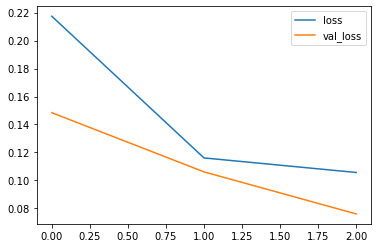

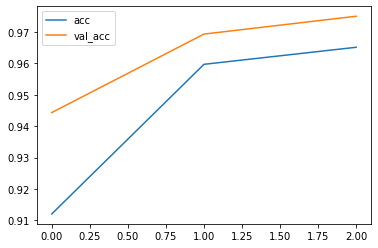

In [11]:
loss = pd.DataFrame(model.history.history)
loss[['loss', 'val_loss']].plot()
loss[['acc', 'val_acc']].plot()

In [12]:
PATH3='../input/construction-worker/construction worker/construction workerx8.png'

In [45]:
# face detection with opencv
def face_detection(img):
    
    face_cascade = cv2.CascadeClassifier('../input/haar-cascades-for-face-detection/haarcascade_frontalface_default.xml')
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
        
    for (x,y,w,h) in faces:
#         cv2.rectangle(img,(x-20,y-20),((x+w)+20,(y+h)+20),(255,0,0),2)
        img = img[y-20:y+h-40, x-20:x+w+20] # for cropping
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return cv_rgb


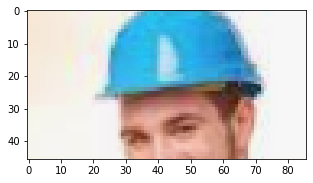

In [46]:
# img = mpimg.imread(test_df['image'][1])
plt.figure(figsize=(5,5))
img = cv2.imread(PATH3)
c=face_detection(img)
plt.imshow(c)

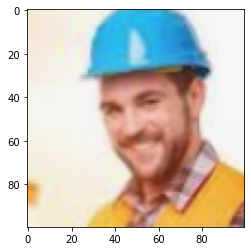

In [39]:
c = transform.resize(c, (100,100))
plt.imshow(c)
# c = c / 255.0

In [40]:
predict_image = np.expand_dims(c, axis=0)

In [41]:
print(predict_image.shape)

(1, 100, 100, 3)


In [42]:
print(predict_image)

[[[[0.96862745 0.90980392 0.84313725]
   [0.96862745 0.90980392 0.84596078]
   [0.96862745 0.91235294 0.84696275]
   ...
   [0.96862745 0.96862745 0.96862745]
   [0.96862745 0.96862745 0.96862745]
   [0.96862745 0.96862745 0.96862745]]

  [[0.96862745 0.90980392 0.84031373]
   [0.96862745 0.90980392 0.84313725]
   [0.96862745 0.91235294 0.84597451]
   ...
   [0.96862745 0.96862745 0.96862745]
   [0.96862745 0.96862745 0.96862745]
   [0.96862745 0.96862745 0.96862745]]

  [[0.96862745 0.90980392 0.8394902 ]
   [0.96862745 0.90980392 0.84231373]
   [0.96862745 0.91069608 0.84402941]
   ...
   [0.96862745 0.96862745 0.96862745]
   [0.96862745 0.96862745 0.96862745]
   [0.96862745 0.96862745 0.96862745]]

  ...

  [[0.96862745 0.93990392 0.88719804]
   [0.96862745 0.93891569 0.88056275]
   [0.96697059 0.93607843 0.87098039]
   ...
   [0.51110784 0.31568627 0.32398039]
   [0.48335294 0.30101373 0.30675098]
   [0.48476471 0.31188431 0.31846863]]

  [[0.96862745 0.94488118 0.89874745]
   [0.9

In [43]:
a = model.predict(predict_image)

In [44]:
print(a)

[[0.01799635]]
